<a href="https://colab.research.google.com/github/krsmith/DS-Unit-2-Sprint-1-Linear-Algebra/blob/master/module4-clustering/Clustering_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Means Clustering

Your assignment is to use the TMDB 5000 dataset from Kaggle to try and cluster similar movies. 

It may be helpful to use PCA to reduce the dimensions of your data first - but then again maybe not. I dunno, you're the data scientist, you tell me. 🤪 

I'll let you download the dataset and get it into your notebook in the way that works best for you:

<https://www.kaggle.com/tmdb/tmdb-movie-metadata/version/2>

There are a few weird data cleaning steps that you'll need to do that I don't want you to get stuck on or spend a lot of time on so I'll try and help you out a little bit. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # You don't necessarily have to use this
from sklearn.cluster import KMeans # You don't necessarily have to use this

df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/tmdb_5000_movies.csv")
print(df.shape)
df.head()

(4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [0]:
# There's probably some pandas function that will do this but...
str_list = [] # empty list to contain columns with strings (words)
for colname, colvalue in df.iteritems():
    if type(colvalue[1]) == str:
         str_list.append(colname)
# Get to the numeric columns by inversion            
num_list = df.columns.difference(str_list)  

In [3]:
# Filter the dataframe by only the numeric columns
df_numeric = df[num_list]
df_numeric.head()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
0,237000000,19995,150.437577,2787965087,162.0,7.2,11800
1,300000000,285,139.082615,961000000,169.0,6.9,4500
2,245000000,206647,107.376788,880674609,148.0,6.3,4466
3,250000000,49026,112.312950,1084939099,165.0,7.6,9106
4,260000000,49529,43.926995,284139100,132.0,6.1,2124


In [6]:
# lazily fill NaNs with zeros
movie_num = df_numeric.fillna(value=0, axis=1)

movie_num.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4803.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.831355,6.092172,690.217989
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.712156,1.194612,1234.585891
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,117.500000,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


# You take it from here!

See what you can come up with. You have all the know-how! 

In [16]:
points = movie_num[['runtime', 'vote_average']]

points.head()

,runtime,vote_average
0,162.0,7.2
1,169.0,6.9
2,148.0,6.3
3,165.0,7.6
4,132.0,6.1


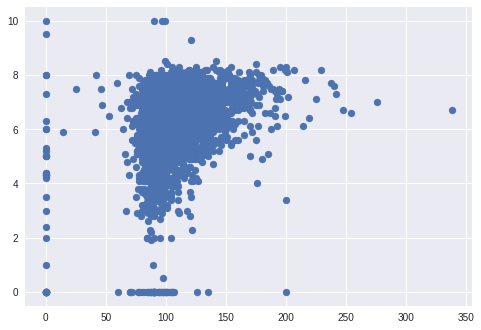

In [17]:
plt.scatter(points.runtime,points.vote_average)
plt.show()

In [18]:
# Calculate the centroid of the entire dataset (only for demonstration purposes)
dataset_centroid_x = points.runtime.mean()
dataset_centroid_y = points.vote_average.mean()

print(dataset_centroid_x, dataset_centroid_y)

106.8313554028732 6.092171559442016


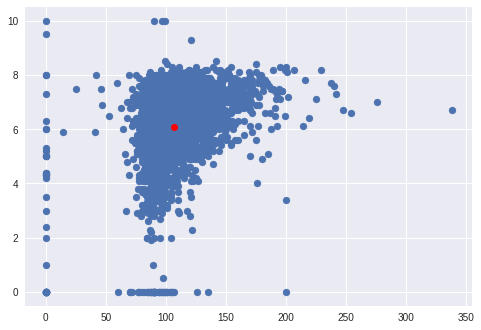

In [20]:
ax = plt.subplot(1,1,1)
ax.scatter(points.runtime,points.vote_average)
ax.plot(dataset_centroid_x, dataset_centroid_y, "or")
plt.show()

In [21]:
centroids = points.sample(3)
centroids.head()

,runtime,vote_average
304,99.0,5.6
2226,85.0,3.2
4136,99.0,6.9


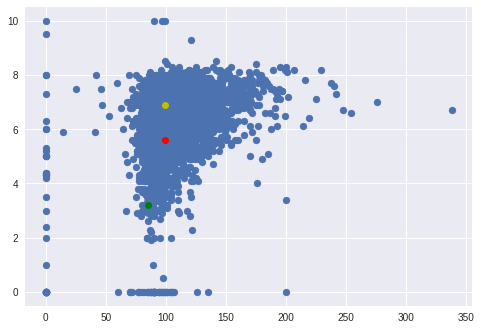

In [23]:
ax = plt.subplot(1,1,1)
ax.scatter(points.runtime,points.vote_average)
ax.plot(centroids.iloc[0].runtime, centroids.iloc[0].vote_average, "or")
ax.plot(centroids.iloc[1].runtime, centroids.iloc[1].vote_average, "og")
ax.plot(centroids.iloc[2].runtime, centroids.iloc[2].vote_average, "oy")
plt.show()

In [0]:
import math
import numpy as np
from scipy.spatial import distance

# Calculate the Nearest Centroid to each data point
def find_nearest_centroid(df, centroids, iteration):
 
  # calculate the distances between each point and each centroid
  distances = distance.cdist(df, centroids, 'euclidean')
  
  # Get nearest centroid to each point based on distance
  nearest_centroids = np.argmin(distances, axis=1)

  se = pd.Series(nearest_centroids)
  df['cluster_'+iteration] = se.values
  
  return df

In [30]:
first_pass = find_nearest_centroid(points.select_dtypes(exclude='int64'), centroids, '1')
first_pass.head()

,runtime,vote_average,cluster_1
0,162.0,7.2,2
1,169.0,6.9,2
2,148.0,6.3,2
3,165.0,7.6,2
4,132.0,6.1,0


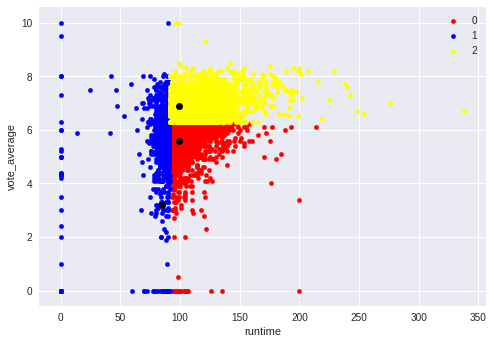

In [34]:
def plot_clusters(df, column_header, centroids):
  colors = {0:'red', 1:'blue', 2:'yellow'}
  fig, ax = plt.subplots()
  ax.plot(centroids.iloc[0].runtime, centroids.iloc[0].vote_average, "ok")
  ax.plot(centroids.iloc[1].runtime, centroids.iloc[1].vote_average, "ok")
  ax.plot(centroids.iloc[2].runtime, centroids.iloc[2].vote_average, "ok")
  grouped = df.groupby(column_header)
  for key, group in grouped:
      group.plot(ax=ax, kind='scatter', x='runtime', y='vote_average', label=key, color=colors[key])
  plt.show()
  
plot_clusters(first_pass, 'cluster_1', centroids)

In [0]:

def get_centroids(df, column_header):
  new_centroids = df.groupby(column_header).mean()
  return new_centroids

centroids = get_centroids(first_pass, 'cluster_1')

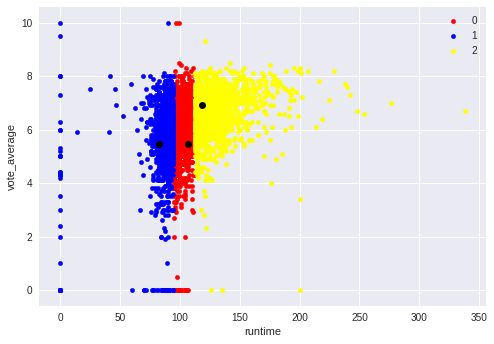

In [36]:
# Calculate New Centroids
centroids = get_centroids(first_pass, 'cluster_1')

# Get Clusters for New Centroids
second_pass = find_nearest_centroid(first_pass.select_dtypes(exclude='int64'), centroids, '2')

# Plot New Cluster
plot_clusters(second_pass, 'cluster_2', centroids)

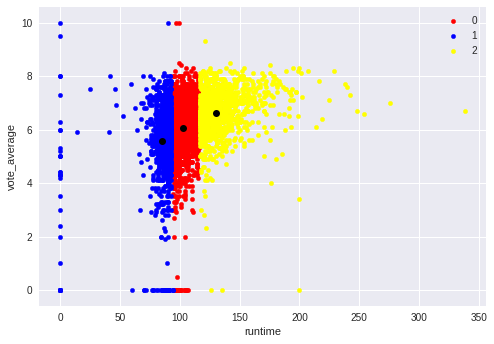

In [37]:

# Calculate New Centroids
centroids = get_centroids(second_pass, 'cluster_2')

# Get Clusters for New Centroids
third_pass = find_nearest_centroid(second_pass.select_dtypes(exclude='int64'), centroids, '3')

# Plot New Cluster
plot_clusters(third_pass, 'cluster_3', centroids)

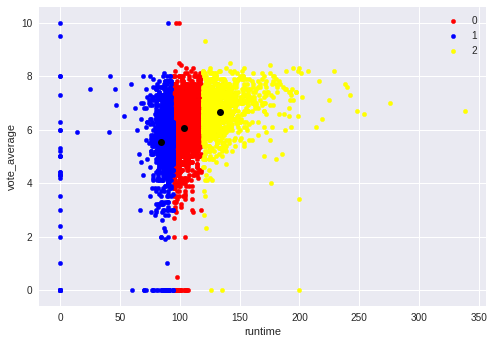

In [38]:
# Calculate New Centroids
centroids = get_centroids(third_pass, 'cluster_3')

# Get Clusters for New Centroids
fourth_pass = find_nearest_centroid(third_pass.select_dtypes(exclude='int64'), centroids, '4')

# Plot New Cluster
plot_clusters(fourth_pass, 'cluster_4', centroids)

In [39]:
convergence = np.array_equal(third_pass['cluster_3'], fourth_pass['cluster_4'])

print("Are we at convergence?? - ", convergence)

Are we at convergence?? -  False


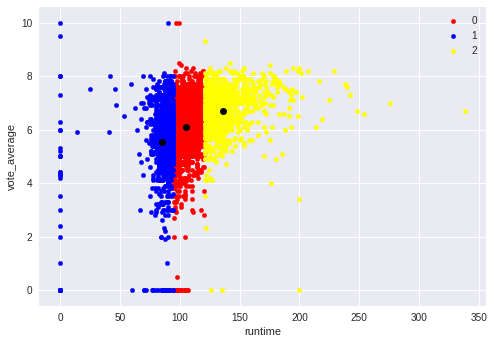

In [40]:
# Calculate New Centroids
centroids = get_centroids(fourth_pass, 'cluster_4')

# Get Clusters for New Centroids
fifth_pass = find_nearest_centroid(fourth_pass.select_dtypes(exclude='int64'), centroids, '5')

# Plot New Cluster
plot_clusters(fifth_pass, 'cluster_5', centroids)

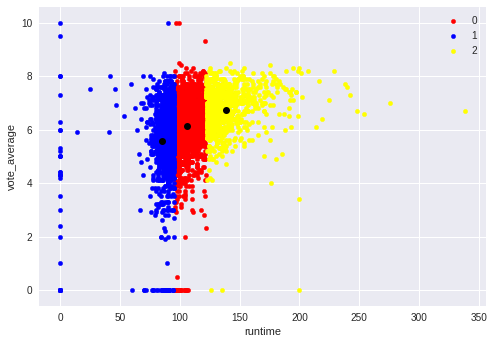

In [42]:
# Calculate New Centroids
centroids = get_centroids(fifth_pass, 'cluster_5')

# Get Clusters for New Centroids
sixth_pass = find_nearest_centroid(fifth_pass.select_dtypes(exclude='int64'), centroids, '6')

# Plot New Cluster
plot_clusters(sixth_pass, 'cluster_6', centroids)

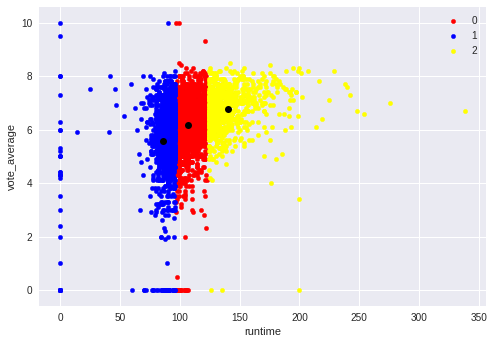

In [52]:
# Calculate New Centroids
centroids = get_centroids(sixth_pass, 'cluster_6')

# Get Clusters for New Centroids
seventh_pass = find_nearest_centroid(sixth_pass.select_dtypes(exclude='int64'), centroids, '7')

# Plot New Cluster
plot_clusters(seventh_pass, 'cluster_7', centroids)

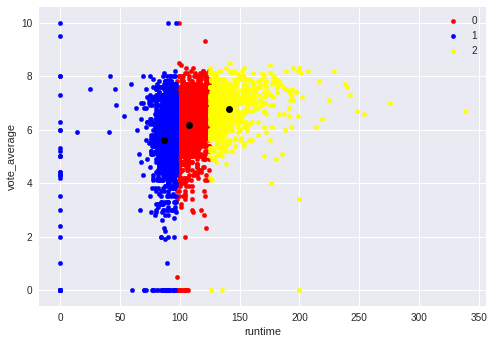

In [53]:
# Calculate New Centroids
centroids = get_centroids(seventh_pass, 'cluster_7')

# Get Clusters for New Centroids
eighth_pass = find_nearest_centroid(seventh_pass.select_dtypes(exclude='int64'), centroids, '8')

# Plot New Cluster
plot_clusters(eighth_pass, 'cluster_8', centroids)

In [54]:
convergence = np.array_equal(seventh_pass['cluster_7'], eighth_pass['cluster_8'])

print("Are we at convergence?? - ", convergence)

# Pass 3-8 are practically identical. Per Ryan, it could be that there are points that switch back and forth
#between centroids and never stop. Given that the data points are SO close together, I believe this to be the case.

Are we at convergence?? -  False


In [45]:
#Using sklearn to compare results

from sklearn.cluster import KMeans 
kmeans = KMeans(n_clusters=3)
kmeans.fit(points)
labels = kmeans.labels_

print(labels)

[1 1 1 ... 2 0 0]


In [50]:
# Add our new labels to the dataframe
new_series = pd.Series(labels)
points['clusters'] = new_series.values

points.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,runtime,vote_average,clusters
0,162.0,7.2,1
1,169.0,6.9,1
2,148.0,6.3,1
3,165.0,7.6,1
4,132.0,6.1,2


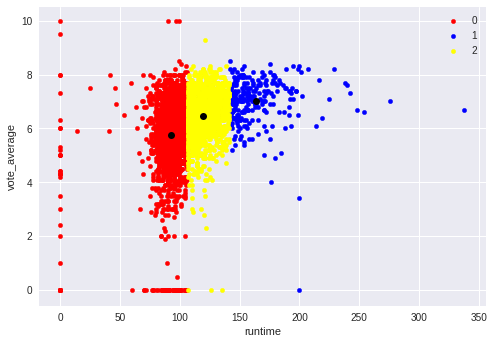

In [51]:
# We might get unlucky with different centroids and have slightly different clusters.
centroids = get_centroids(points, 'clusters')
plot_clusters(points, 'clusters', centroids)

# Stretch Goal:

If you look at the original dataset you'll notice that I threw away some potentially useful columns. See if there are any that you could clean more effectively and turn into a numeric representation (probably some kind of one-hot-encoding of categorical variables) to assist your clustering. There's a lot more work here than the hours we have today however, so don't kill yourself trying to incorporate every single column from the original dataset, just take it one column at a time.

**Side Note** Data Science is never DONE. You just reach a point where the cost isn't worth the benefit anymore. There's always more moderate to small improvements that we could make. Don't be a perfectionist, be a pragmatist.